In [1]:
import numpy as np
from numpy.random import multivariate_normal, randn
from numpy.linalg import norm
from numpy import sqrt
from scipy.linalg import svd
from scipy.linalg.special_matrices import toeplitz
from scipy import linalg
import matplotlib.pylab as plt
import time
from sklearn.utils import shuffle

np.set_printoptions(precision=2)
%matplotlib inline

In [2]:
def beta_func(n_features, sparsity):
    idx = np.arange(n_features)
    beta = (n_features/10)*(-1) ** (abs(idx - 1)) * np.exp(-idx / 10.)
    sel = np.random.permutation(n_features)
    sel1 = sel[0:int(sparsity/4)]
    beta[sel1] = 10
    sel11 = sel[int(sparsity/4):int(sparsity/2)]
    beta[sel11] = -10
    sel0 = sel[sparsity:]
    beta[sel0] = 0.
    return beta

In [3]:
def data1(n_samples, beta, sigma):
    n_features = beta.size
    cov = np.identity(n_features)
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    Y = X.dot(beta) + sigma * randn(n_samples)
    return Y, X

def data2(n_outliers, n_features, type_outliers = 1, beta = 1, rho=1):
    if type_outliers == 1:
        Y = np.ones(n_outliers)
        X = np.ones((n_outliers, n_features))
    elif type_outliers == 2:
        Y = 10000*np.ones(n_outliers)
        X = np.ones((n_outliers, n_features))
    elif type_outliers == 3:
        Y = np.random.randint(2, size = n_outliers)
        X = np.random.rand(n_outliers, n_features)
    else:
        cov = np.identity(n_features)
        X = feature_mat(n_features, n_outliers, rho)
        Y = X.dot(beta) + sigma * randn(n_samples)
    return Y, X
        
def data3(n_heavy_tail, beta, deg = 2):
    n_features = beta.size
    cov = np.identity(n_features)
    X = multivariate_normal(np.zeros(n_features), cov, size=n_heavy_tail)
    Y = X.dot(beta) + np.random.standard_t(deg, size=n_heavy_tail)
    return Y, X

def data_merge_without_shuffle(Y1, X1, Y2, X2):
    Y = np.concatenate((Y1, Y2), axis=0)
    X = np.concatenate((X1, X2), axis=0)
    return Y, X

In [4]:
## Define the objective, subgradient oracle, proximal operator, and gradient for smoothed function (Huber)  
def obj(X, y, w, lamda):
    r = X*w-y;
    return np.sum(np.multiply(r,r))/2 +  lamda * np.sum(np.abs(w))

def subgrad(X, y, w, lamda):
    return  X.T*(X*w-y) + lamda*np.sign(w) 

def f_grad(X, y, w):
    return  X.T*(X*w-y) 

def soft_threshod(w, mu):
    return np.multiply(np.sign(w), np.maximum(np.abs(w)- mu,0))  

def smooth_grad(X, y, w, mu, lamda):
    temp = np.multiply((np.abs(w)<=mu),w/mu) + np.multiply((np.abs(w)>mu),np.sign(w)) 
    return X.T*(X*w-y) + lamda * temp

In [5]:
## ADMM
def ADMM(X_init, y_init, beta_0, max_iter):
    N, dim =  X_init.shape[0], X_init.shape[1]
    error_ADMM = []
    rho = 5
    #print("Lauching ADMM solver...")
    for n in np.arange(10, N):
        X, y = X_init[:n], y_init[:n]
        w = np.matrix([0.0]*dim).T
        z, u = w, w
        lamda = 1/sqrt(N)
        for t in range(0, max_iter):
            #if (t%100==0):
            #    print('iter= {}, estimation error ADMM = {:3f}'.format(t, norm(beta_0 - w)))
            w = np.linalg.solve((X.T)*X + rho*np.identity(dim), X.T*y + rho*z - u)
            z = soft_threshod(w + u/rho, lamda/rho)
            u = u + rho * (w-z)
        error_ADMM.append(norm(beta_0 - w))
    return error_ADMM

In [6]:
N, n_features, sparsity, sigma = 100, 30, 10, 0
np.random.seed(50)

beta_0 = beta_func(n_features, sparsity)
y, X = data1(N, beta_0, sigma)

beta_0 = np.matrix(beta_0).T
y = np.matrix(y).T
X = np.matrix(X)

In [7]:
max_iter = 100 
error_ADMM = ADMM(X, y, beta_0, max_iter)

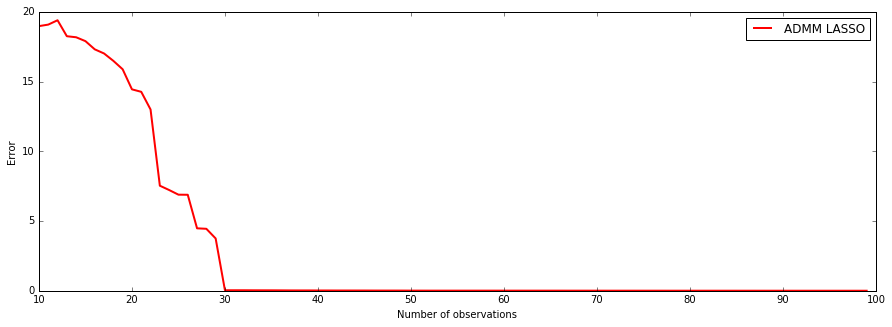

In [8]:
t = np.arange(10, N)
plt.figure(figsize = (15, 5))
plt.plot(t, np.array(error_ADMM), 'r', linewidth = 2, label = 'ADMM LASSO')
plt.legend(prop={'size':12})
plt.xlabel('Number of observations')
plt.ylabel('Error')

## We add one outlier (y=10000, X=ones) at observation number 1000

In [9]:
N, n_features, sparsity, sigma = 100, 30, 10, 0
np.random.seed(50)

beta_0 = beta_func(n_features, sparsity)
y1, X1 = data1(N, beta_0,  sigma)
y2, X2 = data2(1, n_features, type_outliers = 2)
y3, X3 = data1(N, beta_0,  sigma)
y_init, X_init = data_merge_without_shuffle(y1, X1, y2, X2)
y_init, X_init = data_merge_without_shuffle(y_init, X_init, y3, X3)

beta_0 = np.matrix(beta_0).T
y_init = np.matrix(y_init).T
X_init = np.matrix(X_init)

In [10]:
max_iter = 100 
error_ADMM = ADMM(X_init, y_init, beta_0, max_iter)

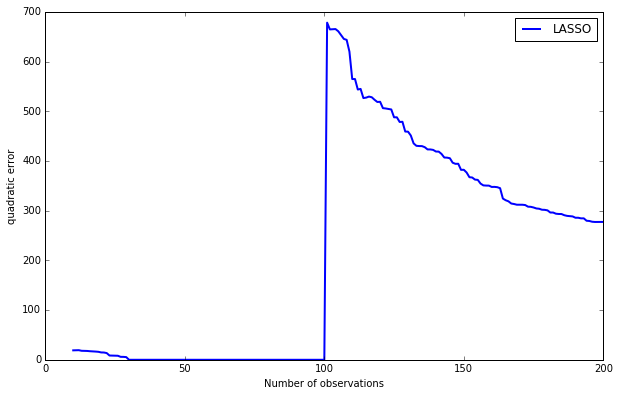

In [18]:
plt.figure(figsize = (10, 6.23))
t = np.arange(10, 2*N+1)

plt.plot(t, np.array(error_ADMM), 'b', linewidth = 2, label = 'LASSO')
plt.legend(prop={'size':12})
plt.xlabel('Number of observations')
plt.ylabel('quadratic error')
filename = 'lasso_non_robust_N{}_d{}_s{}_sigma{}.png'.format(2*N+1, n_features, sparsity, sigma)
plt.savefig(filename)